### Requirements
---

In [1]:
import pandas as pd
pd.__version__

'1.5.3'

In [2]:
import numpy as np
np.__version__

'1.26.4'

In [3]:
import sklearn
sklearn.__version__

'1.5.0'

In [4]:
import tqdm
tqdm.__version__

'4.66.4'

In [5]:
import PIL
PIL.__version__

'10.3.0'

In [6]:
import cv2 as cv
cv.__version__

'4.10.0'

In [7]:
import matplotlib
matplotlib.__version__

'3.9.0'

In [8]:
import webcolors
webcolors.__version__

'24.6.0'

-----

In [9]:
%matplotlib inline

In [10]:
# Standard import
import urllib.request
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

In [11]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off')
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

In [12]:
urls = [
    "https://images.unsplash.com/photo-1604275140373-704beb23bd69?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604277070156-08c968e93206?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1584530028377-28109fdf2411?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604284195847-88dc4b5a9faa?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604287136593-6ef6eac55c3a?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604257769051-c2158a1c5a8c?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60",
    "https://images.unsplash.com/photo-1604274608709-f9c2bb7fc658?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=500&q=60"
]

images = pd.DataFrame(urls)
images.columns = ['urls']
images.head()

,urls
0,https://images.unsplash.com/photo-160427514037...
1,https://images.unsplash.com/photo-160427707015...
2,https://images.unsplash.com/photo-158453002837...
3,https://images.unsplash.com/photo-160428419584...
4,https://images.unsplash.com/photo-160428713659...


In [13]:
# Function to find the closest color based on RGB values
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors._definitions._CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

# Function to find the english name of a given color (actual color or closest one)
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Display color palette for color clusters
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

# Display color palette for color clusters, with percentages (percentages <=> normalized size of clusters)
def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    step = 0
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
    return palette, perc

  0%|          | 0/7 [00:00<?, ?it/s]

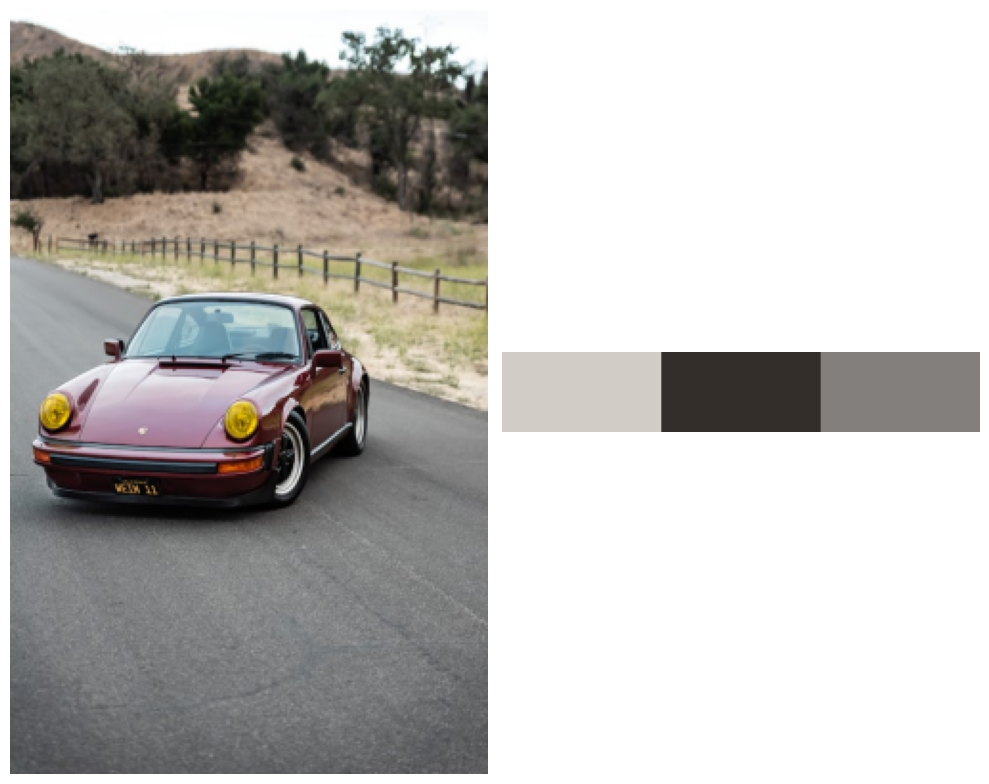

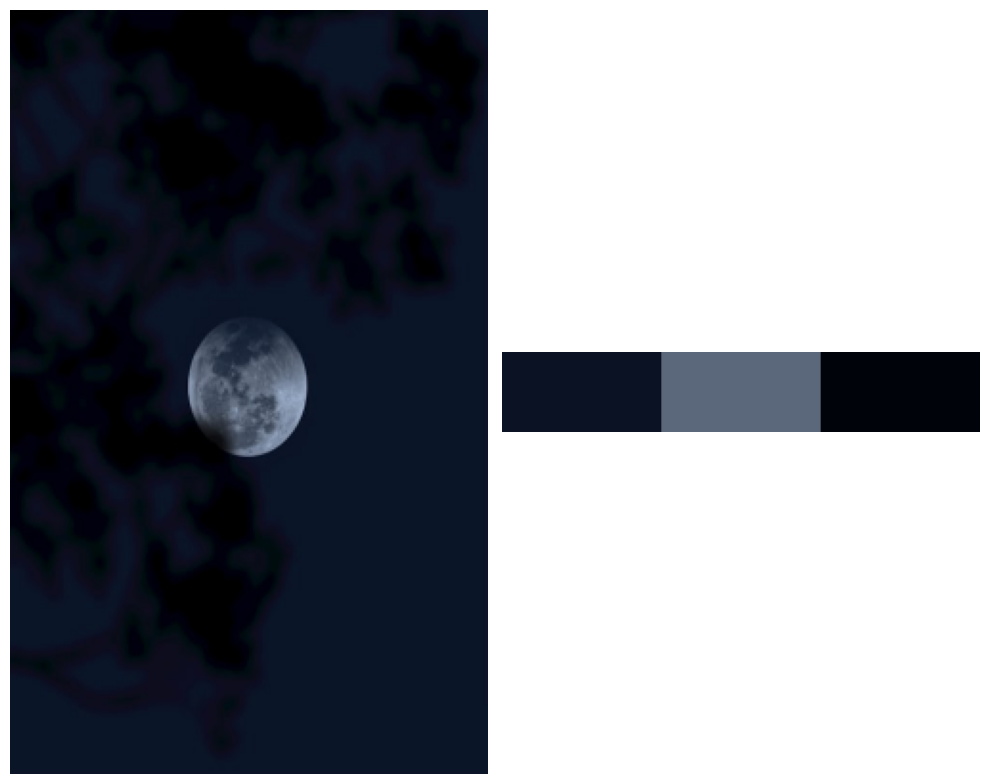

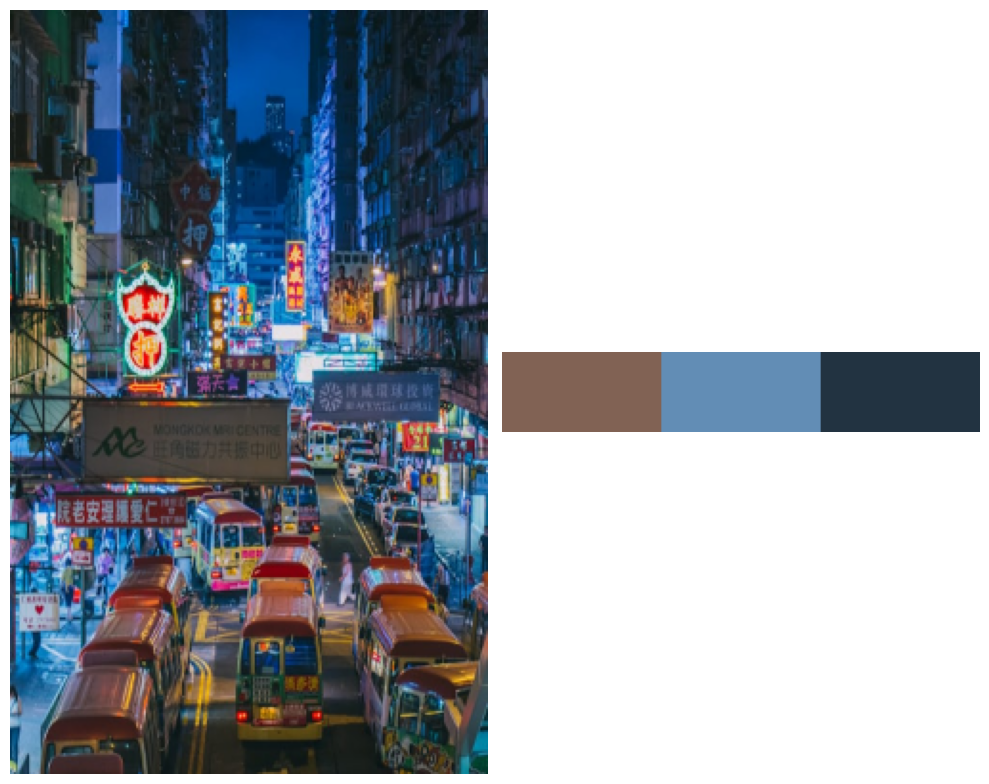

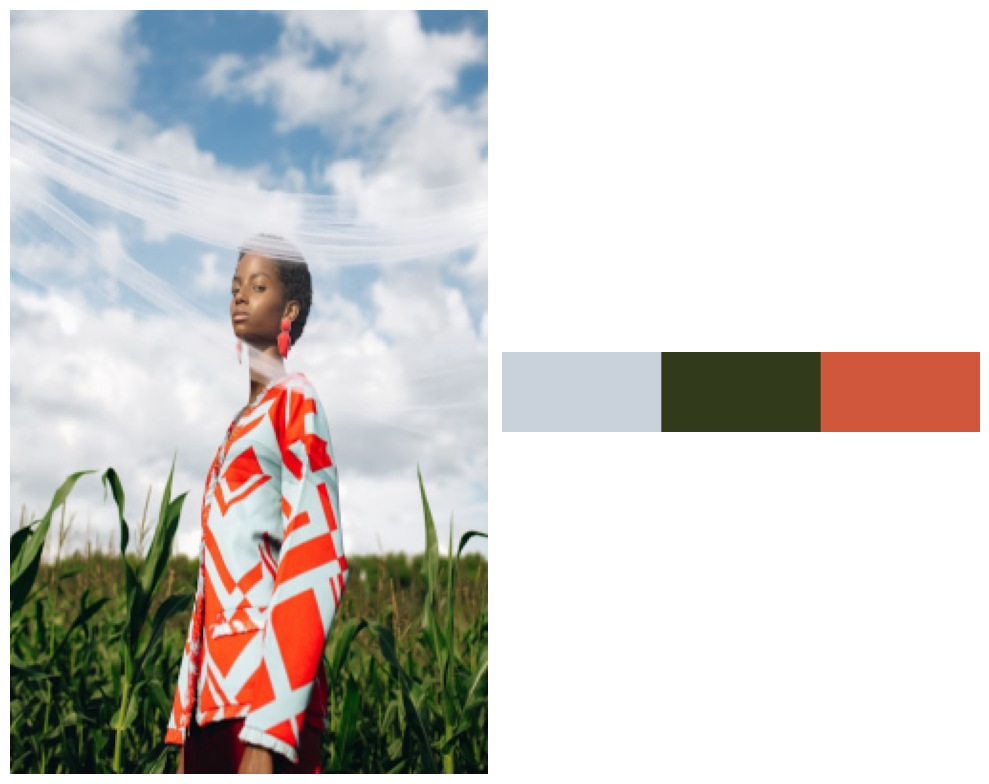

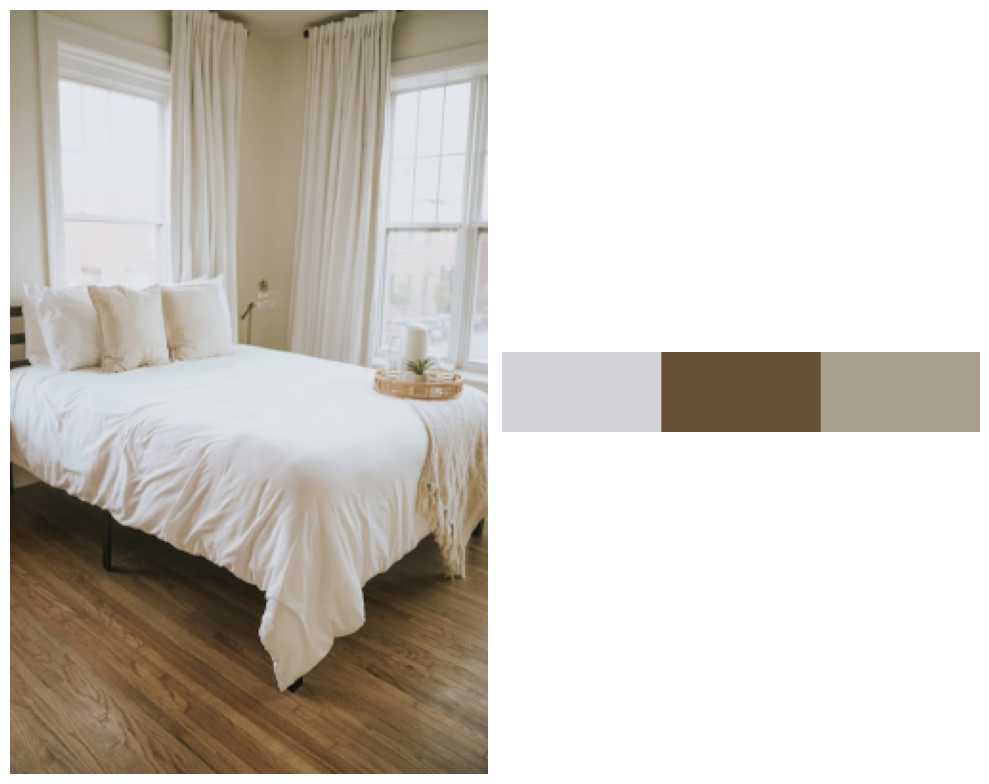

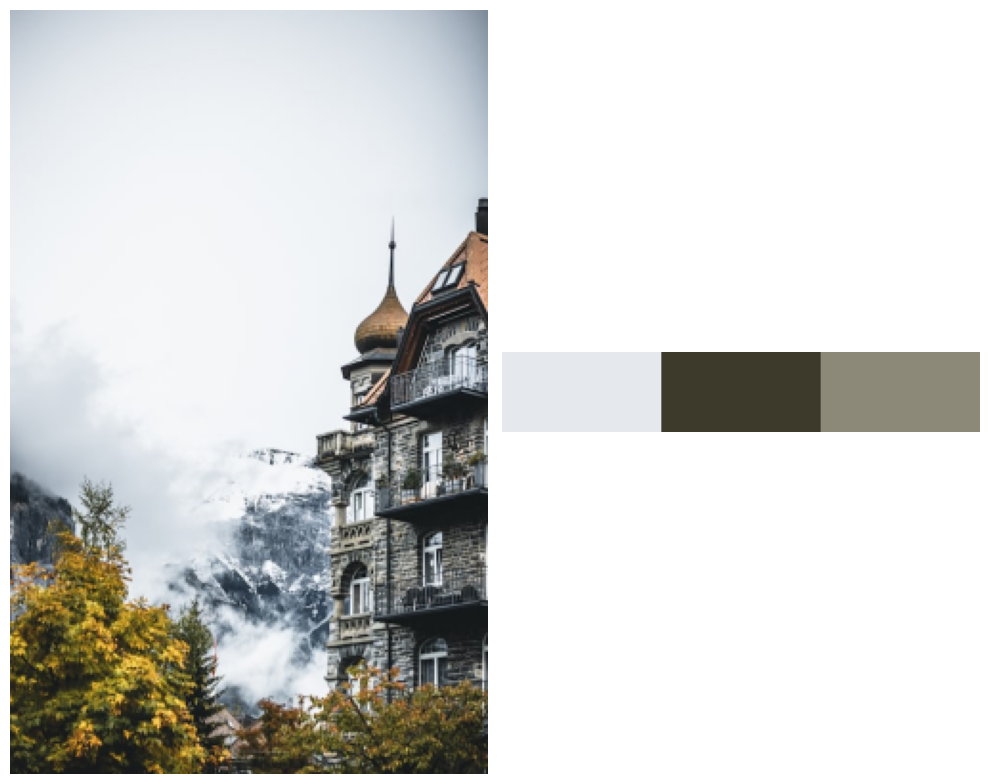

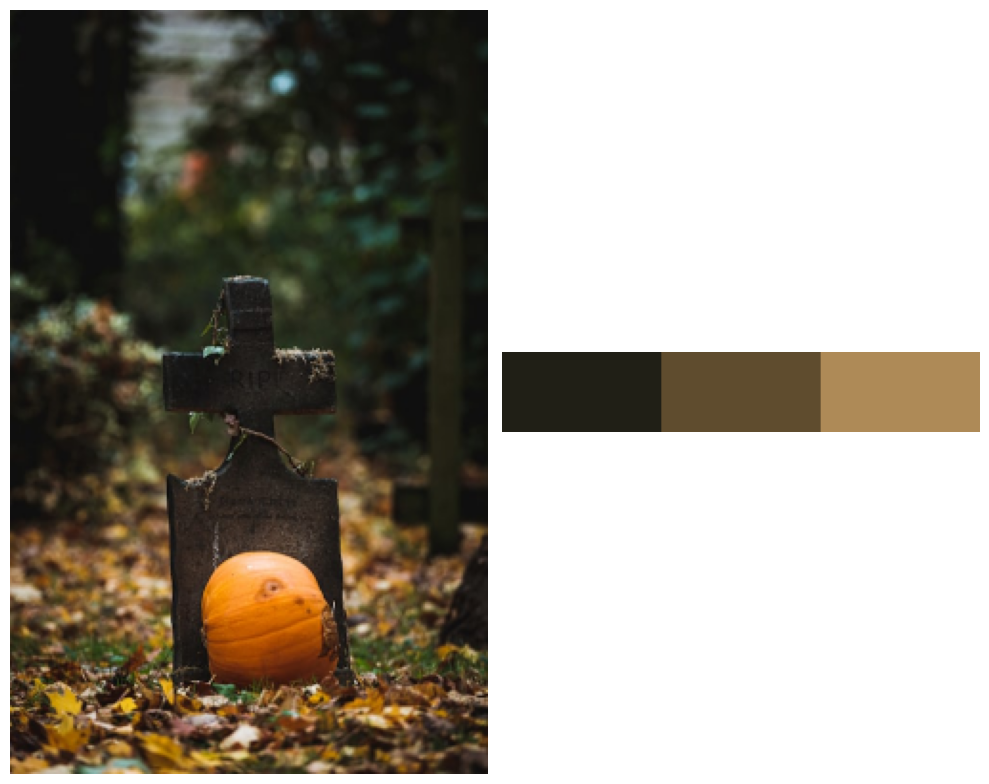

In [14]:
clt=KMeans(n_clusters=3)
urls_colors = []

for url in tqdm(images['urls']):

    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv.imdecode(arr, -1) # 'Load it as it is'
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # resize image
    dim = (250, 400)
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)

    # Fit a KMeans to each image to find the clusters of colors
    clt_1 = clt.fit(img.reshape(-1, 3))
    show_img_compar(img, palette(clt_1))

    colors = {}
    for i in range(3):
        actual_name, closest_name = get_colour_name(tuple([int(x) for x in clt_1.cluster_centers_[i]]))
        if actual_name != None:
            colors[i] = actual_name
        else:
            colors[i] = closest_name

    pal, perc = palette_perc(clt_1)

    data_colors = (url,
                   colors[0],
                   colors[1],
                   colors[2],
                   perc[0],
                   perc[1],
                   perc[2]
                   )

    urls_colors.append(data_colors)

In [15]:
# Create dataframe with colors associated to urls
# Top 3 colors and associated scores
df_colors = pd.DataFrame(urls_colors, columns=['urls', 'color_1', 'color_2', 'color_3', 'score_0', 'score_1', 'score_2'])
df_colors

,urls,color_1,color_2,color_3,score_0,score_1,score_2
0,https://images.unsplash.com/photo-160427514037...,lightgray,darkslategray,gray,0.19,0.24,0.57
1,https://images.unsplash.com/photo-160427707015...,black,dimgray,black,0.64,0.03,0.33
2,https://images.unsplash.com/photo-158453002837...,dimgray,cadetblue,darkslategray,0.18,0.18,0.63
3,https://images.unsplash.com/photo-160428419584...,lightgray,darkslategray,indianred,0.69,0.23,0.08
4,https://images.unsplash.com/photo-160428713659...,lightgray,darkolivegreen,rosybrown,0.38,0.28,0.34
5,https://images.unsplash.com/photo-160425776905...,lavender,darkslategray,gray,0.61,0.23,0.16
6,https://images.unsplash.com/photo-160427460870...,black,darkolivegreen,peru,0.64,0.25,0.12
